# Week 1: Discrete Physics Step Cost Analysis

This notebook explores the **computational and numerical cost of physics simulation** using a minimal system.

The goal is to understand:
- Why physics simulation is expensive
- How timestep (`dt`) affects performance and stability
- Why simulation speed bounds RL training throughput

This experiment is **framework-free**, focusing on first principles.

## Step 0 — Environment Setup

We begin with a minimal setup:
- Python + NumPy
- No physics engines
- No reinforcement learning
- No abstractions

This keeps the system behavior fully visible.

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

## Step 1: Define the Physical State

We simulate a point mass in 2D.

State variables:
- Position: (x, y)
- Velocity: (vx, vy)
- Acceleration: constant (gravity-like)

This is the minimum state required to model motion.

In [ ]:
position = np.array([0.0, 0.0])
velocity = np.array([1.0, 5.0])
acceleration = np.array([0.0, -9.81])

## Step 2: Implement One Physics Step

We use **semi-implicit Euler integration**:
1. Update velocity using acceleration
2. Update position using the updated velocity

This integrator has the same cost as Euler but better stability.

In [ ]:
def physics_step(position, velocity, acceleration, dt):
    new_velocity = velocity + acceleration * dt
    new_position = position + new_velocity * dt
    return new_position, new_velocity

## Step 3: Build the Simulation Loop

The simulator repeatedly applies the physics step.

This loop is the **hottest path** in any physics engine and dominates runtime.

In [ ]:
def run_simulation(position, velocity, acceleration, dt, num_steps):
    start = time.perf_counter()

    for _ in range(num_steps):
        position, velocity = physics_step(
            position, velocity, acceleration, dt
        )

    end = time.perf_counter()
    total_time = end - start
    time_per_step = total_time / num_steps

    return position, velocity, total_time, time_per_step


## Step 4: Fix Total Simulated Time

We simulate the **same amount of physical time** using different timesteps.

This isolates the performance–accuracy trade-off introduced by `dt`.


In [ ]:
TOTAL_SIM_TIME = 5.0
dts = [0.1, 0.01, 0.001]

results = []

for dt in dts:
    num_steps = int(TOTAL_SIM_TIME / dt)

    position = np.array([0.0, 0.0])
    velocity = np.array([1.0, 5.0])
    acceleration = np.array([0.0, -9.81])

    final_pos, final_vel, total_time, time_per_step = run_simulation(
        position, velocity, acceleration, dt, num_steps
    )

    results.append({
        "dt": dt,
        "num_steps": num_steps,
        "total_time": total_time,
        "time_per_step_us": time_per_step * 1e6,
        "final_y": final_pos[1]
    })


## Step 5: Measure Numerical Drift

We compare the simulated final position with the **analytical ground truth**
for constant acceleration motion.

This reveals numerical error accumulation.


In [ ]:
def true_y(y0, v0, a, t):
    return y0 + v0 * t + 0.5 * a * t * t

drift_results = []

for r in results:
    y_true = true_y(0.0, 5.0, -9.81, TOTAL_SIM_TIME)
    drift_results.append({
        "dt": r["dt"],
        "sim_y": r["final_y"],
        "true_y": y_true,
        "error": abs(r["final_y"] - y_true)
    })


## Step 6: Multiple Bodies and State Explosion

We now simulate **N bodies simultaneously**.

Physics remains unchanged.
Only the **state size increases**.

This exposes scalability limits in simulation systems.


In [ ]:
def init_state(num_bodies):
    position = np.zeros((num_bodies, 2))
    velocity = np.zeros((num_bodies, 2))

    velocity[:, 0] = 1.0
    velocity[:, 1] = 5.0

    return position, velocity


In [ ]:
dt = 0.01
num_steps = int(TOTAL_SIM_TIME / dt)
body_counts = [1, 10, 100, 1000]

scaling_results = []

for N in body_counts:
    position, velocity = init_state(N)
    acceleration = np.array([0.0, -9.81])

    _, _, total_time, time_per_step = run_simulation(
        position, velocity, acceleration, dt, num_steps
    )

    scaling_results.append({
        "bodies": N,
        "time_per_step_us": time_per_step * 1e6,
        "total_time": total_time
    })


## Step 7: Energy Tracking (Integrator Quality)

We track:
- Kinetic Energy
- Potential Energy
- Total Energy

Energy drift reveals numerical instability and integrator quality.

In [ ]:
def kinetic_energy(velocity):
    return 0.5 * np.sum(velocity[:, 0]**2 + velocity[:, 1]**2)

def potential_energy(position):
    return np.sum(9.81 * position[:, 1])


In [ ]:
energy_results = []

for dt in dts:
    num_steps = int(TOTAL_SIM_TIME / dt)
    position, velocity = init_state(1)
    
    for _ in range(num_steps):
        position, velocity = physics_step(position, velocity, acceleration, dt)
    
    total_energy = kinetic_energy(velocity) + potential_energy(position)
    
    energy_results.append({
        "dt": dt,
        "total_energy": total_energy
    })


## Final Visualization

We visualize:
- Numerical drift vs timestep
- Energy drift vs timestep
- Simulation cost vs timestep
- Simulation cost vs number of bodies

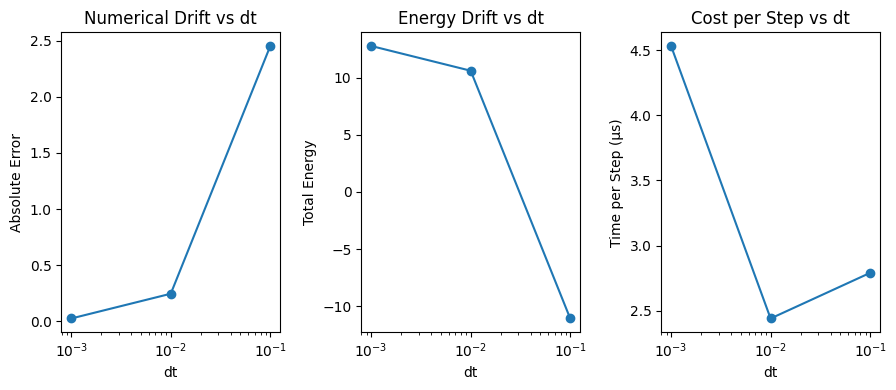

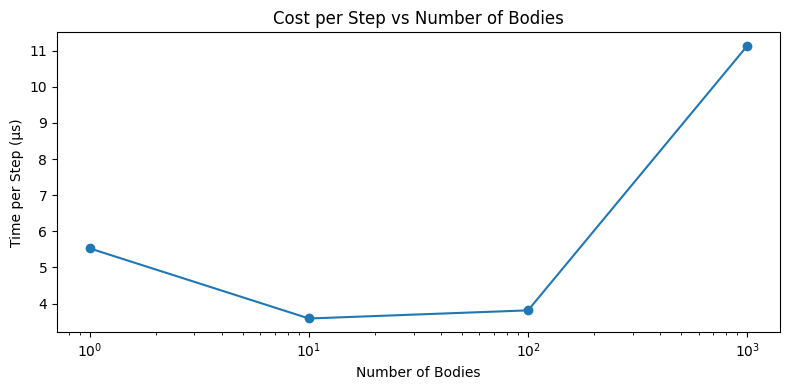

In [ ]:
# Drift plot
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.plot(
    [r["dt"] for r in drift_results],
    [r["error"] for r in drift_results],
    marker="o"
)
plt.xscale("log")
plt.title("Numerical Drift vs dt")
plt.xlabel("dt")
plt.ylabel("Absolute Error")

# Energy plot
plt.subplot(1,4,2)
plt.plot(
    [r["dt"] for r in energy_results],
    [r["total_energy"] for r in energy_results],
    marker="o"
)
plt.xscale("log")
plt.title("Energy Drift vs dt")
plt.xlabel("dt")
plt.ylabel("Total Energy")

# Performance plot
plt.subplot(1,4,3)
plt.plot(
    [r["dt"] for r in results],
    [r["time_per_step_us"] for r in results],
    marker="o"
)
plt.xscale("log")
plt.title("Cost per Step vs dt")
plt.xlabel("dt")
plt.ylabel("Time per Step (µs)")

plt.tight_layout()
plt.show()

# Scaling plot
plt.figure(figsize=(8,4))
plt.plot(
    [r["bodies"] for r in scaling_results],
    [r["time_per_step_us"] for r in scaling_results],
    marker="o"
)
plt.xscale("log")
plt.title("Cost per Step vs Number of Bodies")
plt.xlabel("Number of Bodies")
plt.ylabel("Time per Step (µs)")
plt.tight_layout()
plt.show()

## Final Interpretations

This experiment exposes the fundamental constraints that govern physics-based simulation systems.

### Numerical Stability vs Timestep
As the timestep (`dt`) increases, numerical drift grows rapidly. Smaller timesteps reduce discretization error and improve agreement with the analytical ground truth, while larger timesteps accumulate significant error. This confirms that numerical stability is inherently tied to time discretization and cannot be improved without increasing computational work.

### Energy Drift and Integrator Limitations
The total mechanical energy of the system is not conserved and varies systematically with timestep size. Larger timesteps introduce severe energy drift, including artificial energy injection or dissipation. This behavior is expected for semi-implicit Euler integration, which prioritizes stability and simplicity over energy conservation. Energy drift therefore serves as a diagnostic tool for integrator quality and long-term physical realism.

### Performance Cost of Time Resolution
The cost per simulation step remains approximately constant across timesteps, with small variations due to system-level effects such as timer resolution, cache behavior, and loop overhead. As a result, total simulation cost scales primarily with the number of steps, which is inversely proportional to the timestep. Reducing `dt` improves accuracy but increases runtime linearly.

### State Explosion and Scalability Limits
Increasing the number of simulated bodies increases per-step cost due to growth in state size. Initial scaling benefits from vectorization, but performance degrades sharply once memory hierarchy limits are exceeded. This demonstrates that physics simulation scalability is fundamentally constrained by memory bandwidth and cache behavior, not just arithmetic complexity.

### Core Trade-off
Together, these results reveal an unavoidable trade-off in physics simulation:
- Smaller timesteps and simpler systems improve numerical accuracy and stability but increase computational cost.
- Larger timesteps and larger state sizes improve throughput but degrade physical realism and scalability.

### Systems-Level Insight
Physics simulation is a tight numerical loop whose performance is bounded by timestep resolution and state size. Accuracy, stability, and throughput cannot be optimized simultaneously. These constraints define the upper limits of reinforcement learning training speed, simulator fidelity, and real-time control feasibility. Understanding and navigating this trade-off is essential for designing scalable robotics and reinforcement learning systems.
